<a href="https://colab.research.google.com/github/Qiaochu-Zhang/C-_Grades_with_Hash_Table/blob/main/cs566_basic_model0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")



Using device: cuda


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
!pip install torch torchvision
!pip install opencv-python
!pip install scikit-learn


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, Subset
import cv2
import os
from PIL import Image
import numpy as np
from sklearn.model_selection import KFold
import random


In [ ]:
# 检查是否有GPU可用
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cuda


In [ ]:
# 自定义数据集类，提取噪声作为输入
class NoiseDataset(Dataset):
    def __init__(self, image_folder, label):
        self.image_paths = [os.path.join(image_folder, img) for img in os.listdir(image_folder)]
        self.labels = [label] * len(self.image_paths)
        self.transform = transforms.Compose([
            transforms.Resize((64, 64)),
            transforms.ToTensor()
        ])

    def extract_noise(self, image_path):
        """提取图片的噪声特征"""
        img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        if img is None:
            # 如果无法读取图像，返回None
            return None
        blurred = cv2.GaussianBlur(img, (5, 5), 0)
        noise = cv2.absdiff(img, blurred)  # 计算噪声图
        return Image.fromarray(noise)  # 转换为 PIL 格式

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        # 提取噪声图像
        noise_image = self.extract_noise(self.image_paths[idx])
        if noise_image is None:
            # 如果无法读取图像，则跳过该样本
            return self.__getitem__((idx + 1) % len(self.image_paths))
        img_tensor = self.transform(noise_image)
        label = self.labels[idx]
        return img_tensor, label


In [ ]:
# 定义数据集路径
real_images_path = '/content/drive/MyDrive/Real'  # 请根据您的实际路径调整
ai_images_path = '/content/drive/MyDrive/fake'   # 请根据您的实际路径调整

# 加载数据集：真实图片和AI生成图片
real_dataset = NoiseDataset(real_images_path, label=0)
ai_dataset = NoiseDataset(ai_images_path, label=1)

# 合并数据集
full_dataset = real_dataset + ai_dataset

# 打乱数据集
random.seed(42)
indices = list(range(len(full_dataset)))
random.shuffle(indices)
full_dataset = Subset(full_dataset, indices)

print(f"Total dataset size: {len(full_dataset)}")


Total dataset size: 201


In [ ]:
# 定义K折交叉验证
k_folds = 5
kfold = KFold(n_splits=k_folds, shuffle=True, random_state=42)


In [ ]:
# 定义 CNN 模型
class NoiseCNN(nn.Module):
    def __init__(self):
        super(NoiseCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, 3, padding=1)  # 输入为灰度图 (1通道)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.fc1 = nn.Linear(32 * 16 * 16, 128)
        self.fc2 = nn.Linear(128, 2)  # 输出为2类：真实或AI生成

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(-1, 32 * 16 * 16)  # 展平张量
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x


In [ ]:
# 准备交叉验证
results = {}
num_epochs = 5

for fold, (train_ids, val_ids) in enumerate(kfold.split(range(len(full_dataset)))):
    print(f'\nFold {fold + 1}')
    print('--------------------------------')

    # 定义训练和验证数据集
    train_subsampler = torch.utils.data.SubsetRandomSampler(train_ids)
    val_subsampler = torch.utils.data.SubsetRandomSampler(val_ids)

    # 定义数据加载器
    train_loader = torch.utils.data.DataLoader(
                      full_dataset,
                      batch_size=8, sampler=train_subsampler)
    val_loader = torch.utils.data.DataLoader(
                      full_dataset,
                      batch_size=8, sampler=val_subsampler)

    # 初始化模型、损失函数和优化器
    model = NoiseCNN().to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # 开始训练
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for batch_idx, (data, target) in enumerate(train_loader):
            data = data.to(device)
            target = target.to(device)

            optimizer.zero_grad()
            outputs = model(data)
            loss = criterion(outputs, target)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        avg_loss = running_loss / len(train_loader)
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {avg_loss:.4f}')

    # 验证模型
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data, target in val_loader:
            data = data.to(device)
            target = target.to(device)
            outputs = model(data)
            _, predicted = torch.max(outputs.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()
    accuracy = 100 * correct / total
    print(f'Fold {fold + 1} Accuracy: {accuracy:.2f}%')

    # 保存结果
    results[fold] = accuracy



Fold 1
--------------------------------
Epoch [1/5], Loss: 0.7041
Epoch [2/5], Loss: 0.6972
Epoch [3/5], Loss: 0.6941
Epoch [4/5], Loss: 0.6938
Epoch [5/5], Loss: 0.6935
Fold 1 Accuracy: 53.66%

Fold 2
--------------------------------
Epoch [1/5], Loss: 0.6948
Epoch [2/5], Loss: 0.6926
Epoch [3/5], Loss: 0.6950
Epoch [4/5], Loss: 0.6934
Epoch [5/5], Loss: 0.6930
Fold 2 Accuracy: 42.50%

Fold 3
--------------------------------
Epoch [1/5], Loss: 0.7000
Epoch [2/5], Loss: 0.6903
Epoch [3/5], Loss: 0.6752
Epoch [4/5], Loss: 0.6586
Epoch [5/5], Loss: 0.6033
Fold 3 Accuracy: 62.50%

Fold 4
--------------------------------
Epoch [1/5], Loss: 0.7028
Epoch [2/5], Loss: 0.6935
Epoch [3/5], Loss: 0.6929
Epoch [4/5], Loss: 0.6892
Epoch [5/5], Loss: 0.6942
Fold 4 Accuracy: 42.50%

Fold 5
--------------------------------
Epoch [1/5], Loss: 0.6924
Epoch [2/5], Loss: 0.7067
Epoch [3/5], Loss: 0.6836
Epoch [4/5], Loss: 0.6688
Epoch [5/5], Loss: 0.6251
Fold 5 Accuracy: 77.50%


In [ ]:
# 打印每个折的结果
print('\nK-FOLD CROSS VALIDATION RESULTS')
print('--------------------------------')
sum_acc = 0.0
for key, value in results.items():
    print(f'Fold {key + 1}: {value:.2f}%')
    sum_acc += value
print(f'Average Accuracy: {sum_acc/len(results):.2f}%')



K-FOLD CROSS VALIDATION RESULTS
--------------------------------
Fold 1: 53.66%
Fold 2: 42.50%
Fold 3: 62.50%
Fold 4: 42.50%
Fold 5: 77.50%
Average Accuracy: 55.73%



Fold 1
--------------------------------
Epoch [1/5], Loss: 0.7006
Validation Accuracy: 53.66%
Epoch [2/5], Loss: 0.6941
Validation Accuracy: 46.34%
Epoch [3/5], Loss: 0.6948
Validation Accuracy: 46.34%
Epoch [4/5], Loss: 0.6939
Validation Accuracy: 46.34%
Epoch [5/5], Loss: 0.6938
Validation Accuracy: 46.34%


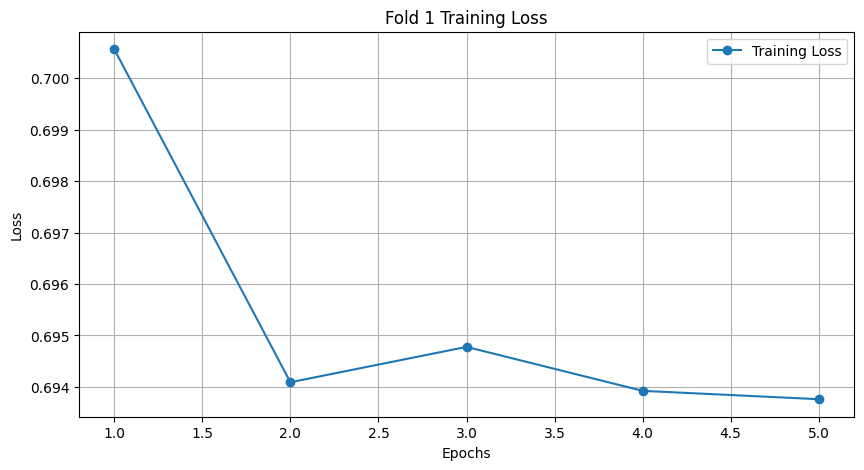

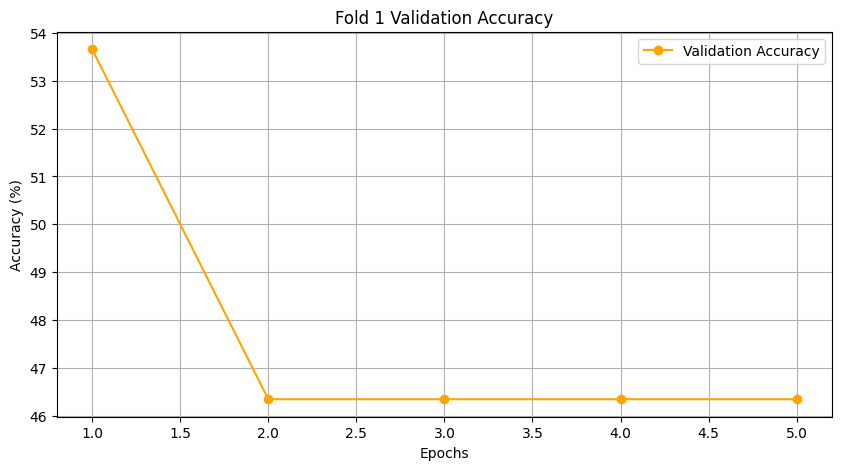

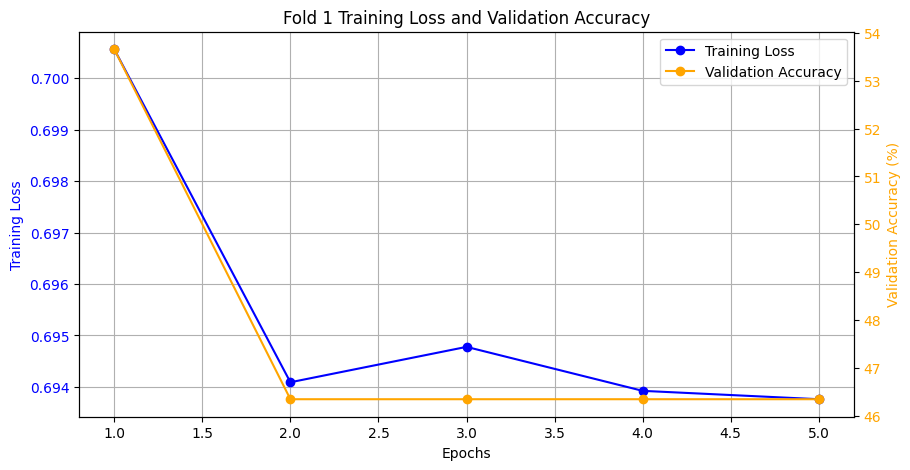


Fold 2
--------------------------------
Epoch [1/5], Loss: 0.7036
Validation Accuracy: 42.50%
Epoch [2/5], Loss: 0.6932
Validation Accuracy: 42.50%
Epoch [3/5], Loss: 0.6903
Validation Accuracy: 42.50%
Epoch [4/5], Loss: 0.6916
Validation Accuracy: 42.50%
Epoch [5/5], Loss: 0.6892
Validation Accuracy: 45.00%


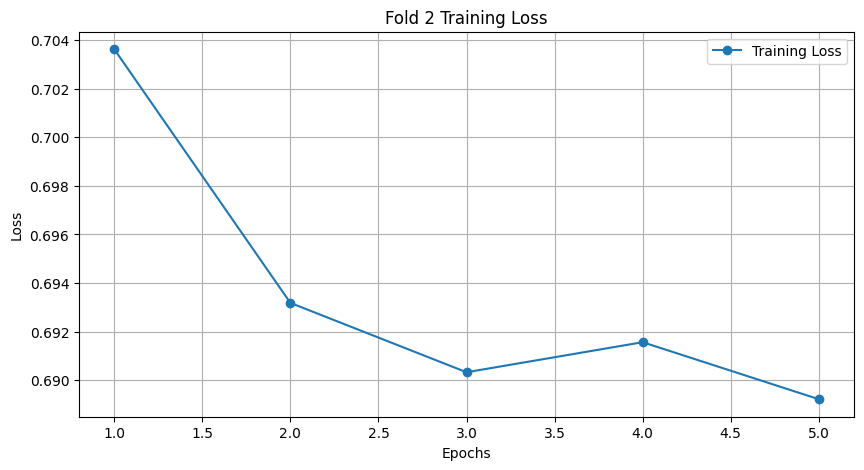

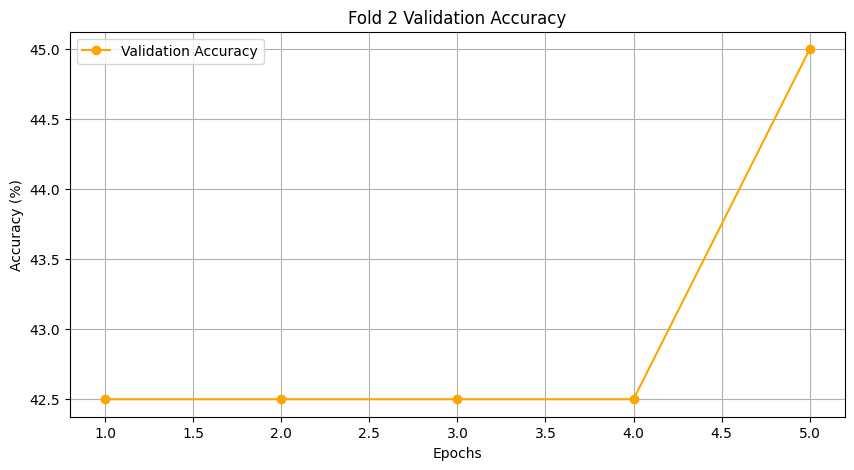

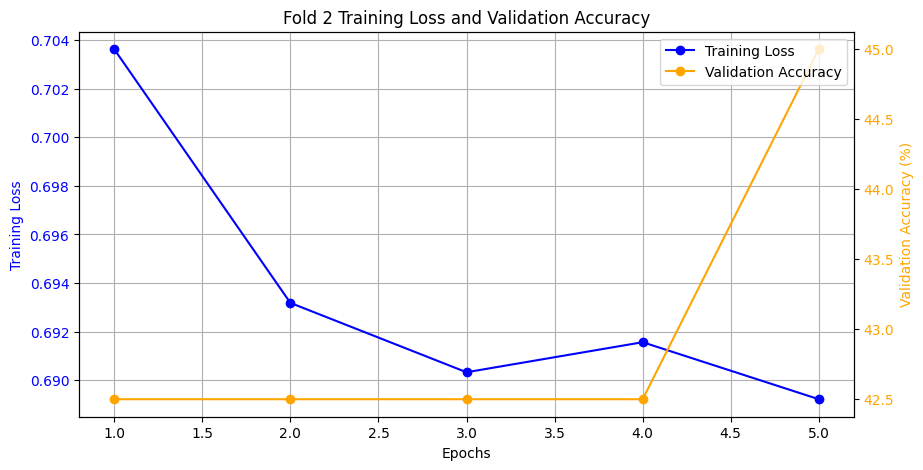


Fold 3
--------------------------------
Epoch [1/5], Loss: 0.7126
Validation Accuracy: 57.50%
Epoch [2/5], Loss: 0.6987
Validation Accuracy: 57.50%
Epoch [3/5], Loss: 0.6949
Validation Accuracy: 45.00%
Epoch [4/5], Loss: 0.6920
Validation Accuracy: 42.50%
Epoch [5/5], Loss: 0.6931
Validation Accuracy: 42.50%


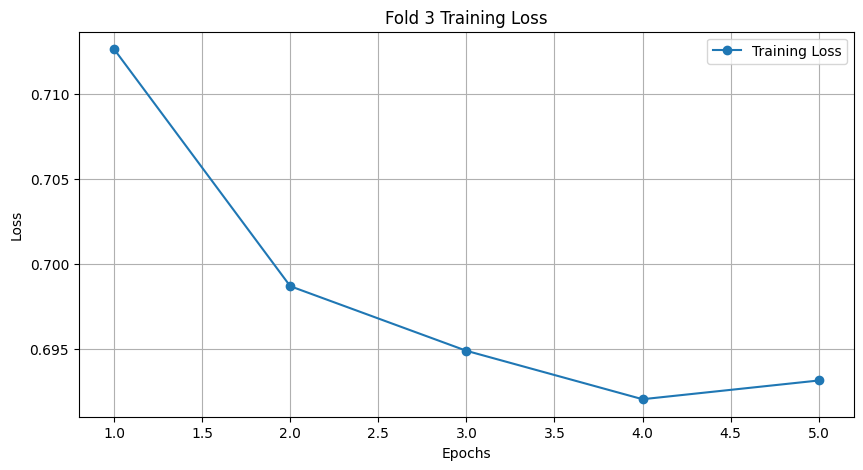

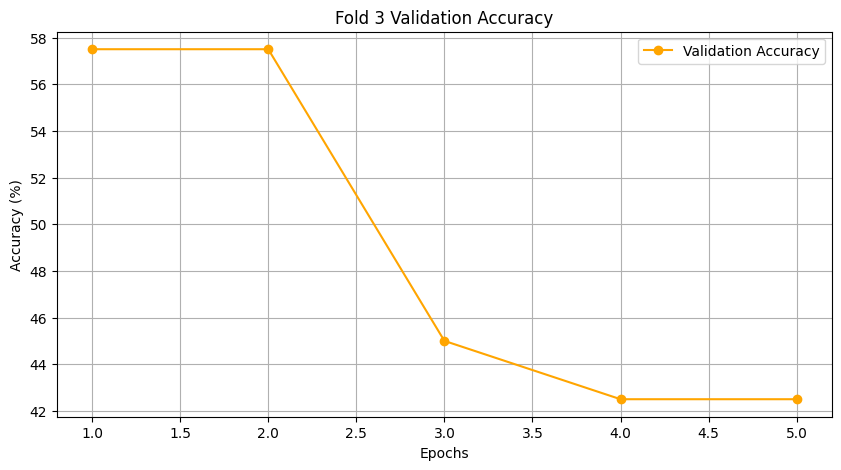

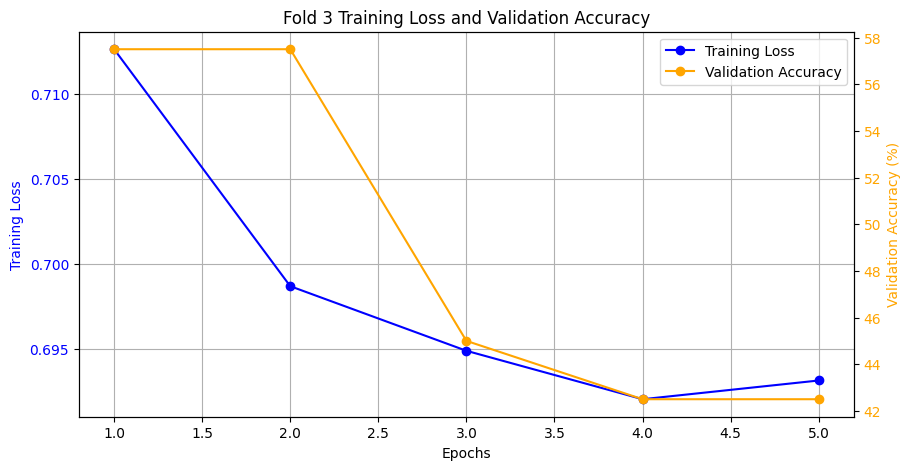


Fold 4
--------------------------------
Epoch [1/5], Loss: 0.7034
Validation Accuracy: 42.50%
Epoch [2/5], Loss: 0.6940
Validation Accuracy: 42.50%
Epoch [3/5], Loss: 0.6910
Validation Accuracy: 65.00%
Epoch [4/5], Loss: 0.6807
Validation Accuracy: 42.50%
Epoch [5/5], Loss: 0.6781
Validation Accuracy: 67.50%


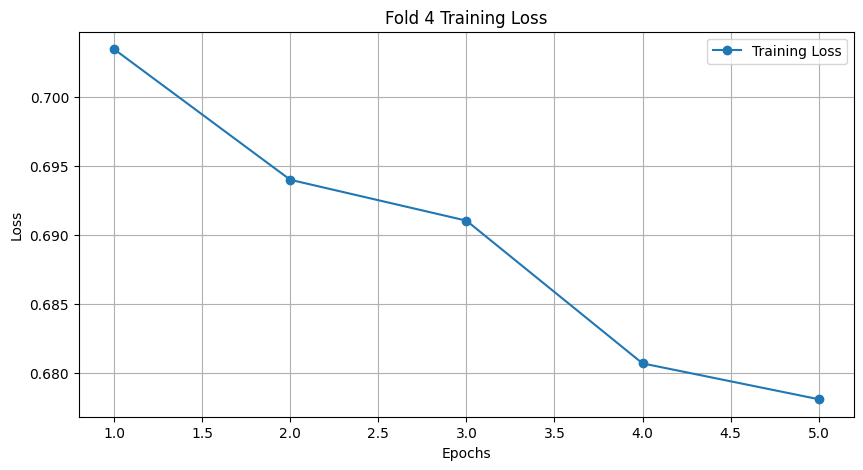

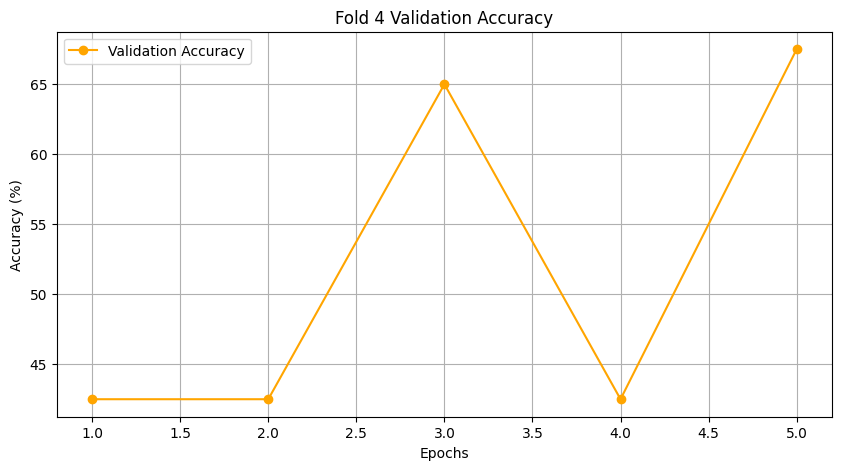

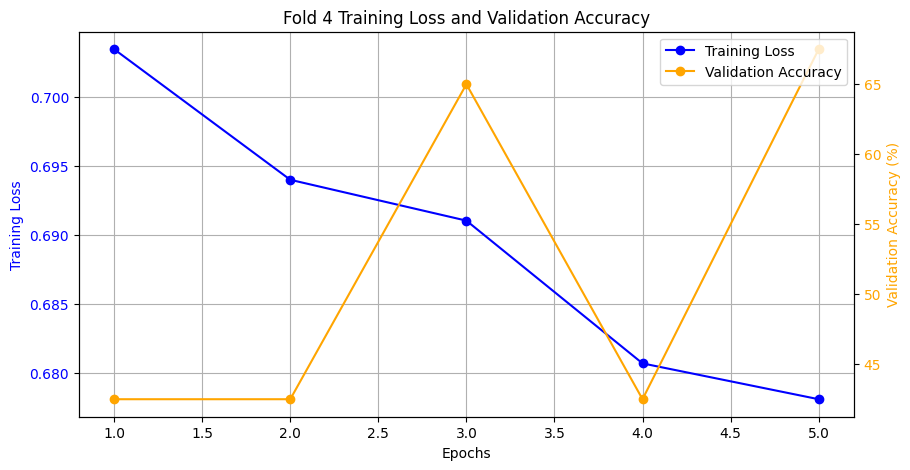


Fold 5
--------------------------------
Epoch [1/5], Loss: 0.7216
Validation Accuracy: 62.50%
Epoch [2/5], Loss: 0.6961
Validation Accuracy: 62.50%
Epoch [3/5], Loss: 0.6970
Validation Accuracy: 62.50%
Epoch [4/5], Loss: 0.6970
Validation Accuracy: 37.50%
Epoch [5/5], Loss: 0.6940
Validation Accuracy: 37.50%


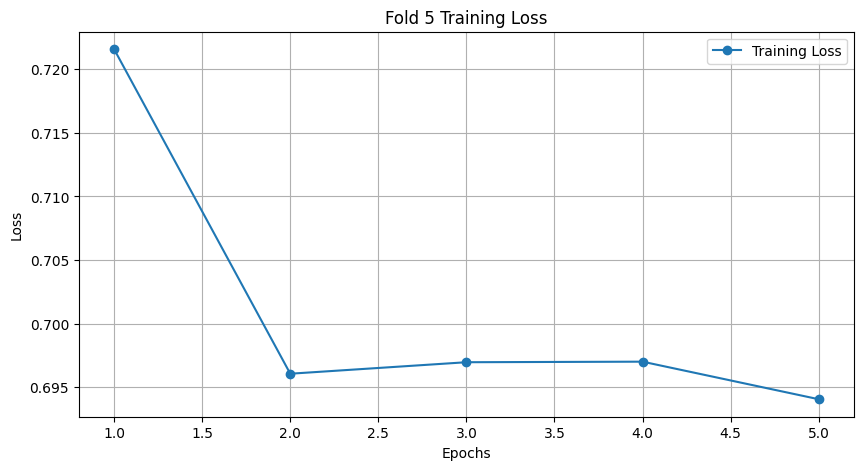

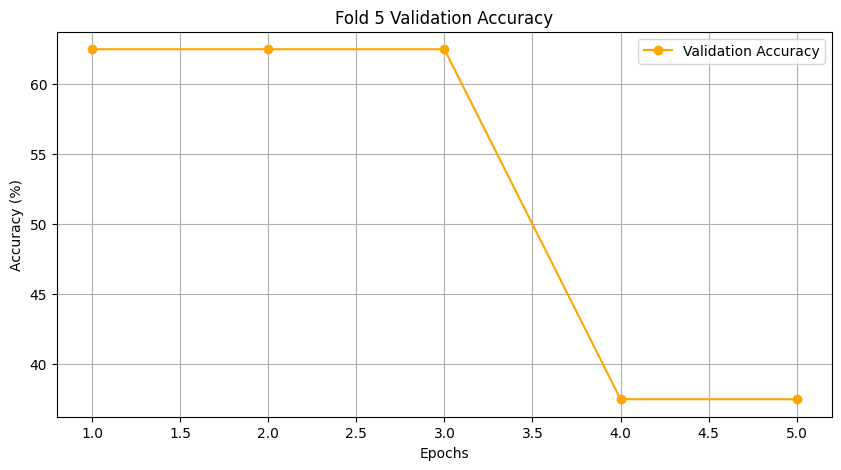

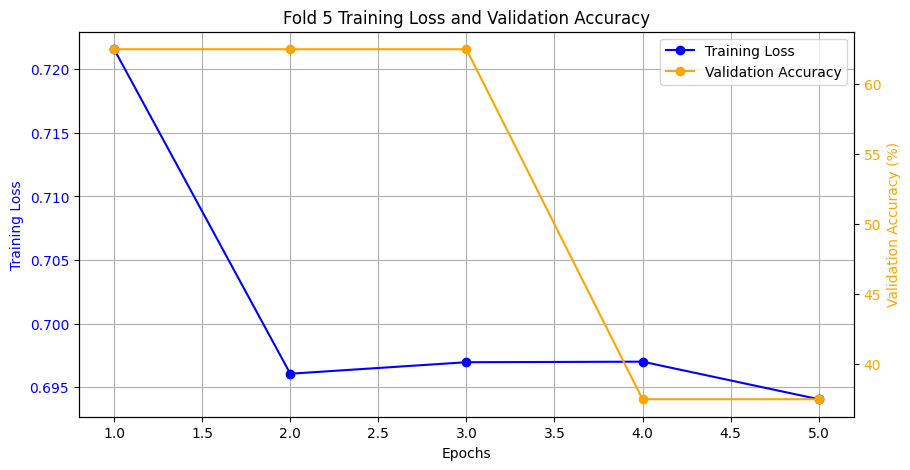

In [ ]:
# Step 7: 准备交叉验证并训练模型
import matplotlib.pyplot as plt

k_folds = 5
kfold = KFold(n_splits=k_folds, shuffle=True, random_state=42)

results = {}
num_epochs = 5

for fold, (train_ids, val_ids) in enumerate(kfold.split(range(len(full_dataset)))):
    print(f'\nFold {fold + 1}')
    print('--------------------------------')

    # 在fold开始时，初始化列表用于保存训练损失和验证准确率
    train_losses = []
    val_accuracies = []

    # 定义训练和验证数据集
    train_subsampler = torch.utils.data.SubsetRandomSampler(train_ids)
    val_subsampler = torch.utils.data.SubsetRandomSampler(val_ids)

    # 定义数据加载器
    train_loader = torch.utils.data.DataLoader(
                      full_dataset,
                      batch_size=8, sampler=train_subsampler)
    val_loader = torch.utils.data.DataLoader(
                      full_dataset,
                      batch_size=8, sampler=val_subsampler)

    # 初始化模型、损失函数和优化器
    model = NoiseCNN().to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # 开始训练
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for batch_idx, (data, target) in enumerate(train_loader):
            data = data.to(device)
            target = target.to(device)

            optimizer.zero_grad()
            outputs = model(data)
            loss = criterion(outputs, target)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        avg_loss = running_loss / len(train_loader)
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {avg_loss:.4f}')

        # 记录训练损失
        train_losses.append(avg_loss)

        # 在验证集上评估模型
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for data, target in val_loader:
                data = data.to(device)
                target = target.to(device)
                outputs = model(data)
                _, predicted = torch.max(outputs.data, 1)
                total += target.size(0)
                correct += (predicted == target).sum().item()
        accuracy = 100 * correct / total
        print(f'Validation Accuracy: {accuracy:.2f}%')

        # 记录验证准确率
        val_accuracies.append(accuracy)

    # 绘制训练损失曲线
    plt.figure(figsize=(10,5))
    plt.title(f'Fold {fold + 1} Training Loss')
    plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss', marker='o')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

    # 绘制验证准确率曲线
    plt.figure(figsize=(10,5))
    plt.title(f'Fold {fold + 1} Validation Accuracy')
    plt.plot(range(1, num_epochs + 1), val_accuracies, label='Validation Accuracy', color='orange', marker='o')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.grid(True)
    plt.show()

    # 或者在同一张图中绘制
    fig, ax1 = plt.subplots(figsize=(10,5))
    ax1.set_title(f'Fold {fold + 1} Training Loss and Validation Accuracy')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Training Loss', color='blue')
    ax1.plot(range(1, num_epochs + 1), train_losses, label='Training Loss', color='blue', marker='o')
    ax1.tick_params(axis='y', labelcolor='blue')
    ax1.grid(True)

    ax2 = ax1.twinx()
    ax2.set_ylabel('Validation Accuracy (%)', color='orange')
    ax2.plot(range(1, num_epochs + 1), val_accuracies, label='Validation Accuracy', color='orange', marker='o')
    ax2.tick_params(axis='y', labelcolor='orange')

    fig.legend(loc='upper right', bbox_to_anchor=(1,1), bbox_transform=ax1.transAxes)
    plt.show()

    # 保存结果
    results[fold] = val_accuracies[-1]  # 使用最后一个epoch的验证准确率
